In [445]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation

In [446]:
# Parameters 
L = 10 # length of domain 
dx = 0.2 # mesh steps 
nx = int(L / dx) # mesh points
k0s = np.linspace(0.1, 5, nx) # momentum of wave pakcket [au] (0.01 to 5) with nx points
# T = L / (2 * k0s) # total time 
dt = 2 * dx**2 # time step 
# nt = (T / dt) # time points 

x = np.linspace(0, L, nx)

In [447]:
# Gaussian wave packet
def get_psi0(k0): 
    x0 = L / 4  # center of the wave packet
    sigma = L / 20  # width of the wave packet
    N = (np.pi * sigma ** 2)**(-1/4) # Normalization 
    gaussian = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
    phase = np.exp(1j * k0 * x) 
    psi0 = (gaussian * phase) * N # initial wave function
    # norm = np.sum(psi0 * np.conj(psi0)) * dx # check in psi0 is normalized
    # print(norm)
    return psi0 

In [448]:
# Potential initial conditions 
V0 = 1 # potential strength
a = 0.05 # potential width percentage 
V = np.zeros(nx)
V[int((nx - a * nx) / 2):int((nx + a * nx) / 2)] = V0 # indices for start and end of the well 


In [449]:
# Build coefficient matrix, a+
aplus = np.zeros((nx, nx),complex)
nu = 1j * dt / (4 * dx**2) # kinetic energy operator must be less than one to be stable

for i in range(len(aplus) - 1): # off diagonal 
    aplus[i,i+1] = aplus[i+1,i] = -nu 

for i in range(len(aplus)): # diagonal
    aplus[i,i] = 1 + 2 * nu 

aplus_inv = np.linalg.inv(aplus)
print(nu)


0.5j


In [450]:
# Build coefficient matrix, a-
aminus = np.zeros((nx, nx),complex)

for i in range(len(aminus)-1): # off diagonal 
    aminus[i,i+1] = aminus[i+1,i] = nu  

for i in range(len(aminus)): # diagonal
    aminus[i,i] = 1 - 2 * nu 

In [451]:
# Crank-Nicholson
def get_psi():
    final_psis = []
    for k0 in k0s:
        current_T = L / (2 * k0)
        current_nt = int(current_T / dt) 
        psi0 = get_psi0(k0)
        for t in range(current_nt): 
            f = np.exp(-1j * dt * V) * psi0
            psi = np.dot(aplus_inv, np.dot(aminus, f))
            psi0 = psi
        
    # # # plotting 
    #         if k0 == 2 and t % 10.0 == 0:
    #             # plt.plot(x, np.abs(psi))#, label=f'Time step: {t}')
    #             plt.figure(figsize=(10, 300))
    #             num_cols = 2  # Number of columns for subplots
    #             num_rows = (current_nt + num_cols - 1) // num_cols

    #             plt.subplot(num_rows, num_cols, t + 1)
    #             plt.plot(x, np.abs(psi)**2)
    #             plt.plot(x, V)
    #             plt.title(f'Time step: {t}, velocity: {k0}')
    #             plt.xlabel('Position')
    #             plt.ylabel('Wave function')
    #             plt.tight_layout()
    #     plt.show()
        final_psis.append(psi)
    
    return final_psis, k0s       

Reflection coefficient (R): [0.23629218420861664, 0.33432056031025237, 0.7574745833152727, 0.6819694711674947, 0.6215434488930274, 0.584572675530299, 0.602226494169048, 0.6507724807283248, 0.6243475921771616, 0.5531959824222953, 0.5020088934693494, 0.47393518854590133, 0.4087442994463619, 0.3811941991838665, 0.3746009076961715, 0.3579483535641581, 0.35025770183528837, 0.3368976751191046, 0.32260674017841207, 0.3038235040737727, 0.29136134453139945, 0.27502995238146893, 0.25993694509830567, 0.24603351232459594, 0.24187095170755835, 0.2216147496961245, 0.21123810303183777, 0.20195385406377328, 0.19388944531664856, 0.18771690158364576, 0.1702313332520578, 0.16606727301332744, 0.16237127063986934, 0.14637110628565025, 0.14475424555036148, 0.12973634758252198, 0.13450877017163637, 0.12063679010738759, 0.10785631130628542, 0.11635396316686526, 0.10479488448810699, 0.10458190439861018, 0.09360720233353217, 0.08379750637796902, 0.07998768894458784, 0.07058336671264, 0.06255938160373896, 0.0559

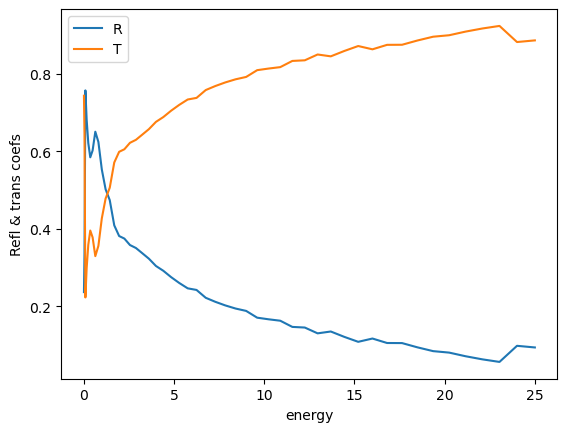

In [452]:
# Reflection and transmisison coefficients 
center = int(nx/2) # center of well
psi, k0s = get_psi() 
rcoefs = []
tcoefs = []

for i, _ in enumerate(k0s): 
    current_psi = psi[i]
    reflected_wavefunction = current_psi[0: center]
    transmitted_wavefunction = current_psi[center: nx] 
    refl = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx
    trans = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx
    rcoefs.append(np.real(refl))
    tcoefs.append(np.real(trans))


print(f"Reflection coefficient (R): {rcoefs}")
print(f"Transmission coefficient (T): {tcoefs}")
# print(len(tcoefs))
# print((k0s))

es = k0s**2 / np.array(V0) # unitless energy

plt.plot(es, rcoefs, label = 'R')
plt.plot(es, tcoefs, label = 'T')
plt.xlabel("energy")
plt.ylabel('Refl & trans coefs')
plt.title('')
plt.legend()
plt.show()

In [453]:
# Ramsauer-Townsend
# k0s = [10, 15, 20, 30, 35, 40, 45, 50, 60, 70, 75, 80, 90, 100, 110, 120, 130, 140] * np.array(np.pi) 
# es = k0s**2 / np.array(V0) # unitless energy 
# rs = [0.99, 0.98, 0.95, 0.68, 0.38, 0.13, 0.05, 0.05, 0.03, 0.01, 0.02, 0.03, 0.02, 0.01, 0.05, 0.06, 0.02, 0.05]
# ts = [0.01, 0.02, 0.05, 0.32, 0.62, 0.86, 0.95, 0.95, 0.97, 0.99, 0.98, 0.97, 0.98, 0.99, 0.95, 0.94, 0.98, 0.95]
# plt.plot(es, rs, label= 'R')
# plt.plot(es, ts, label = 'T')
# plt.xlabel("energy")
# plt.ylabel('Refl & trans coefs')
# plt.title('')
# plt.legend()
# plt.show()
# # print([k0] * nx)
# print(rs[9])

In [454]:
# f = np.exp(-1j * dt * V) * psi0
# # plt.plot(x, V)
# plt.plot(x, f.real)
# plt.plot(x, f.imag)
# plt.show()